In [226]:
import numpy as np
import matplotlib.pyplot as plt

# First we create a gray background image:

In [227]:
o = np.empty((128,128),dtype = 'float64')

for i in range(0,128):
    for j in range(0,128):
        o[i,j] = np.float64(.5)
        

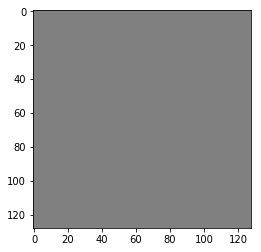

In [228]:
plt.imshow(o,cmap='gray', vmin=0, vmax=1)
plt.show()

# Now we going to put a bunch of little circles, dots, onto this image.
This will be our object, aka, what we are going to image.

In [229]:
num_of_circles = np.random.randint(20, high = 40, size=1)[0]

for i in range(0,num_of_circles):
    centerx = np.random.randint(5, high = 125, size = 1)[0]
    centery = np.random.randint(5, high = 125, size = 1)[0]
    radius = np.random.randint(1, high = 8, size = 1)[0]
    for ix in range(0,128):
        for iy in range(0,128):
            if (ix-centerx)**2 + (iy-centery)**2 <= radius:
                o[ix,iy] = 0
            #elif (ix-centerx)**2 + (iy-centery)**2 > radius**2 and (ix-centerx)**2 + (iy-centery)**2 <= radius**2 + (np.floor(radius*.6))**2:
             #   o[ix,iy] = .3

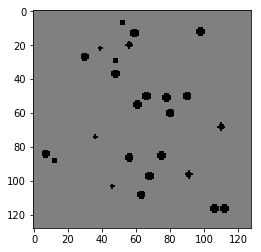

In [230]:
plt.imshow(o,cmap='gray', vmin=0, vmax=1)
plt.show()

# We need to then run a Fourier Transform on this object.
The fft shifts just pre and post process the object so that we can run the fourier transform.

In [231]:
O = np.fft.ifftshift(np.fft.fftn(np.fft.fftshift(o)))

# Alright, now we create a pupil function.
Yes, what is a pupil function? Well, I too spent a lot of time trying to figure out what exactly a pupil function is. Essentially, a pupil function is a mathematical function (in our case it will end up being a matrix), that defines the pupil on an imaging system. So in real life, these can be quite complicated. In our case, we are just going to make a circle, white in the middle and dark all around it.

In [232]:
# probably the most complicated and cumbersome way to create a circle.
a = np.zeros((128,128))
ex = np.linspace(-2,2-4/128,128)
ey = np.linspace(-2,2-4/128,128)
[xx,yy] = np.meshgrid(ex,ey)
rr = np.sqrt((xx)**2 +(yy)**2)
for i in range(0,len(ex)):
    for j in range(0,len(ey)):
        if rr[i,j]<=1:
            a[i,j] = 1

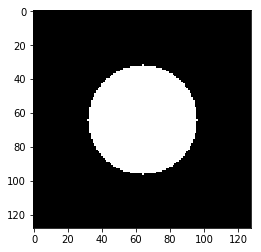

In [233]:
plt.imshow(a,cmap='gray', vmin=0, vmax=1)
plt.show()

# A brief intermezzo: Zernike Polynomials
Okay, so we now have our object that we want to image and the aperture that we want to image it through. We now, however, need to learn about the Zernike polynomails, which are a set of functions that will allow us to introduce any aberration into our optical system -- mathematically! These are things like coma, tilt, tip, astigmatism, and, especially for us, blur!

In [234]:
# defining the zernike polynomials function 
def zernike(c, r, theta, one):
    #zmxy: z = zernike, m = if present, following number is negative, x = m or azmuthal, and y = n or radial
    z00  = c[0] * one #pistion
    z11  = c[1] * (2 * r * np.cos(theta)) #x-tilt
    zm11 = c[2] * (2 * r * np.sin(theta)) #y-tilt
    z02  = c[3] * np.sqrt(3) * (-one + 2 * r**2)  #defocus
    zm22 = c[4] * np.sqrt(6) * (r**2 * np.sin(2 * theta)) #x-astig
    z22  = c[5] * np.sqrt(6) * (r**2 * np.cos(2 * theta)) #y-astig
    zm13 = c[6] * np.sqrt(8) * (3 * r**3 - 2 * r) * np.sin(theta) #x-coma
    z13  = c[7] * np.sqrt(8) * (3 * r**3 - 2 * r) * np.cos(theta) #y-coma
    zm33 = c[8] * np.sqrt(8) * r**3 * np.sin(3 * theta) #vertical trefoil
    z33  = c[9] * np.sqrt(8) * r**3 * np.cos(3 * theta) #horizontal trefoil
    
    z = z00 + z11 + zm11 + z02 + zm22 + z22 + zm13 + z13 + zm33 + z33
    
    return z

# Creating a phase
We now will create a matrix that will have some aberration in it (e.g. blur). This will be known as the phase.

In [235]:
x = np.linspace(-2,2-4/128,128)
[X,Y] = np.meshgrid(x,x)
r = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y,X)
[X,Y] = np.meshgrid(r,t)
one = np.ones((np.size(x),np.size(x)))

In [236]:
c1 = [0 for i in range(0,10)] #c vector, which just assigns weights to each zernike
c1[3] = .5 #add some defocus
Theta1 = zernike(c1,r,theta,one) # returns fourth zernike polynomial: c(4).*sqrt(3).*(-one + 2.*r.^2)

#  This is what our phase looks like

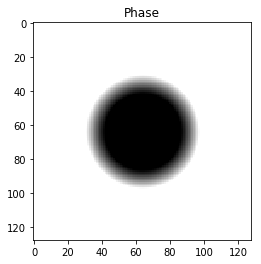

In [237]:
plt.imshow(Theta1,cmap='gray', vmin=0, vmax=1)
plt.title('Phase')
plt.show()

In [238]:
# We also can create defocus based on some "camera" parameters
lambdaa = 550E-9 #wavelength nm
deltaz = 20E-6   # defocus in mm i think
radius = 32 #pixels
focal = 73 #pixels for na = .4

phase_defocus = -np.pi * deltaz / lambdaa * radius**2 / focal**2 * r**2
phi = np.exp(1j * phase_defocus)

In [239]:
def image_calc(phase, add_phase = 1):
    H1 = a * add_phase * np.exp(2 * np.pi * 1j * phase)
    h1 = np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(H1)))
    p1 = np.abs(h1)**2
    P1 = np.fft.ifftshift(np.fft.fftn(np.fft.fftshift(p1)))
    Z1 = np.multiply(O, P1)
    z1 = np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(Z1))).real
    
    return z1

## Now the algorithm begins:
Everything up to this point has been to computationally model an object being imaged with defocus. We now have two images, z1 and z2, that are blurred from the original object o. Lets see how all these look:

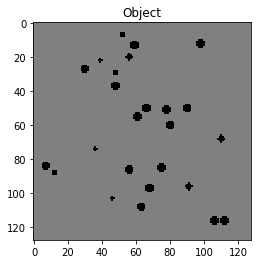

In [240]:
plt.imshow(o,cmap='gray', vmin=0, vmax=1)
plt.title('Object')
plt.show()

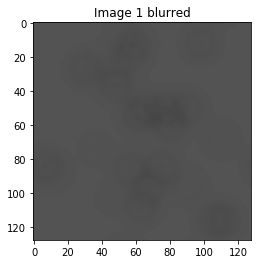

In [241]:
z1 = image_calc(Theta1)
plt.imshow(z1,cmap='gray', vmin=0, vmax=.3)
plt.title('Image 1 blurred')
plt.show()

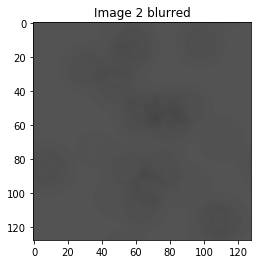

In [242]:
z2 = image_calc(Theta1,phi)
plt.imshow(z2,cmap='gray', vmin=0, vmax=.3)
plt.title('Image 2 blurred')
plt.show()

# I know, I know, its hard to see. Here it is with some other colors to show contrast.

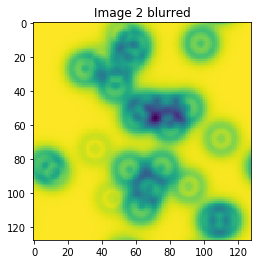

In [243]:
plt.imshow(z2)
plt.title('Image 2 blurred')
plt.show()

# Now we Guess:
This is really the beginning of the algorithm. From here on out, we assume that the only thing we know is that we have two images that are blurry and we will know how much more blurry the second one is from the first (aka, phi). We are going to figure out what the unblurred image is. First we take a wile guess as to what a c vector could be. From that, we construct to guess images, and a guess as to what the ublurred image could be.

In [244]:
c = [0 for i in range(0,10)]
Phat1 = image_calc(zernike(c,r,theta,one))
Phat2 = image_calc(zernike(c,r,theta,one),phi)
Ohat = (np.conj(Phat1) * np.fft.ifftshift(np.fft.fftshift(np.fft.fftshift(Z1))) + np.conj(Phat2) * np.fft.ifftshift(np.fft.fftshift(np.fft.fftshift(Z2)))) / (abs(Phat1) ** 2 + abs(Phat2)**2 + 1e-20)
error = np.sum(np.sum(abs(z1 - np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(Ohat * Phat1))))**2)) + np.sum(np.sum(abs(z2 - np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(Ohat * Phat2))))**2))

In [245]:
q1 = 1
q2 = 1
q3 = 1
q4 = 1
q5 = 1
q6 = 1
cg= [0 for i in range(0,10)]
counter = 0
errorlist = []

In [246]:
for i in range(0,50):
    c = cg
    c[3] = c[3] + q4 * 0.05
    
    Thetag = zernike(c,r,theta,one);
    #Thetag = ZernikeMap(c,X,Y,[0 0 1]);
    
    Phatg1 = image_calc(Thetag)
    Phatg2 = image_calc(Thetag,phi)
    
    Ohatg = (np.conj(Phatg1) * np.fft.ifftshift(np.fft.fftshift(np.fft.fftshift(Z1))) + np.conj(Phatg2) * np.fft.ifftshift(np.fft.fftshift(np.fft.fftshift(Z2)))) / (abs(Phatg1)**2 + abs(Phatg2)**2 + 1e-20)
    
    errorg = np.sum(np.sum(abs(z1 - np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(Ohatg * Phatg1))))**2)) + np.sum(np.sum(abs(z2 - np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(Ohatg * Phatg2))))**2))

    if errorg < error:
        cg[3] = c[3]
    elif errorg > error:
        q3 = -1
    else:
        q3 = 0;
        cg[3] = c[3];

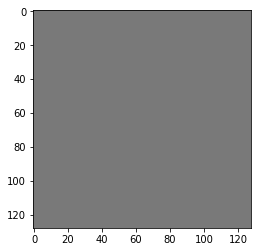

In [251]:
Thetag = zernike(cg,r,theta,one)
ohatg = image_calc(Thetag)
plt.imshow(ohatg,cmap='gray', vmin=0, vmax=.2)
plt.show()